In [1]:
import pandas as pd
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt.expected_returns import mean_historical_return
from sqlalchemy import create_engine
import numpy as np
import cvxpy as cp
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
mpl.rcParams['figure.dpi'] = 150

(CVXPY) Jul 14 05:13:59 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jul 14 05:13:59 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


#### Import Data & Initial Description

In [2]:
engine = create_engine('sqlite:///GDS_IndividualProject.db', echo=False)

df_sample = pd.read_sql_table('sample', con=engine, index_col='Date')
df_mkt_cap = pd.read_sql_table('market_cap', con=engine, index_col='Date')
df_sector = pd.read_sql_table('sectors', con=engine)
df_emissions = pd.read_sql_table('emissions', con=engine)
df_esg = pd.read_sql_table('esg', con=engine)

In [3]:
df_emissions

,RIC,Total Revenue,"CO2 Equivalent Emissions Direct, Scope 1","CO2 Equivalent Emissions Indirect, Scope 2",Carbon Intensity
0,AA,12451000000,1.740000e+07,4400000.000,1750.863384
1,AXP,54389000000,1.794400e+04,80275.000,1.805861
2,BA,66608000000,6.120000e+05,756000.000,20.538074
3,PEP.O,86392000000,3.596712e+06,1811114.000,62.596375
4,CAT,59427000000,7.400000e+05,800000.000,25.914147
...,...,...,...,...,...
1035,IR,5916300000,3.599900e+04,58812.000,16.025387
1036,FANG.O,9643000000,1.252665e+06,528224.000,184.682049
1037,DBX.O,2324900000,1.053000e+03,37106.000,16.413179
1038,TROX.K,3454000000,2.400000e+06,2000000.000,1273.885350


In [4]:
df_sample.drop('2017-12', inplace=True) # Returns data so drop 1st row

df_sector = df_sector.sort_values('Instrument')

df_emissions = df_emissions.loc[df_emissions['RIC'].isin(df_sample.columns.to_list())].sort_values('RIC').reset_index(drop=True)
df_esg = df_esg.loc[df_esg['RIC'].isin(df_sample.columns.to_list())].sort_values('RIC').reset_index(drop=True)

df_emission_scores = df_emissions[['RIC', 'Carbon Intensity']].merge(df_esg, on='RIC', how='outer')

In [5]:
df_sector_count = df_sector.groupby('TRBC Economic Sector Name').count().sort_values('Instrument', ascending=False)

In [6]:
df_sector_mc = (df_mkt_cap.tail(1).T).merge(df_sector, left_index=True, right_on='Instrument').drop(
    'Instrument', axis=1).rename(columns={'2022-12': 'Market Cap'})
df_sector_mc = (df_sector_mc.groupby('TRBC Economic Sector Name').sum().sort_values('Market Cap', ascending=False))/10**9
df_sector_mc['Market Cap Proportion'] = df_sector_mc['Market Cap'] / df_sector_mc['Market Cap'].sum()*100

In [74]:
df_desc = df_sector_count.merge(df_sector_mc, left_index=True, right_index=True).rename(
    columns={'Instrument': 'Count', 'Market Cap': 'Market Cap (USD Billions)'})

df_desc = df_desc.style.format({
    'Market Cap (USD Billions)': '{:,.2f}'.format,
    'Market Cap Proportion': '{:,.2f}%'.format,
})

df_desc

,Count,Market Cap (USD Billions),Market Cap Proportion
TRBC Economic Sector Name,,,
Industrials,19,380.10,14.61%
Technology,16,695.07,26.72%
Consumer Cyclicals,14,239.70,9.22%
Basic Materials,10,123.36,4.74%
Energy,10,88.29,3.39%
Real Estate,10,106.55,4.10%
Healthcare,9,406.89,15.64%
Financials,6,134.97,5.19%
Consumer Non-Cyclicals,4,393.71,15.14%


In [8]:
# Bootstrap to fill missing values
for column in df_sample.columns:
    df_sample[[column]] = df_sample[[column]].apply(
        lambda x: np.where(x.isnull(), x.dropna().sample(len(x), replace=True, random_state=123), x))

#### Benchmark Portfolio

In [9]:
benchmark_weights = (df_mkt_cap/(df_mkt_cap.sum(axis=1).values.reshape(-1,1))).tail(1).T.rename(columns={'2022-12': 'Weight'})
benchmark_returns = pd.DataFrame((benchmark_weights['Weight'].values*df_sample).sum(axis=1), columns=['Benchmark Returns'])

In [10]:
benchmark_weights

Date,Weight
ABM,0.001120
ABT,0.073595
ACN,0.067542
ADBE.O,0.060149
AFL,0.017197
...,...
WDAY.O,0.016533
WK,0.001696
WMT,0.147007
ZBRA.O,0.005090


In [11]:
mu_benchmark_monthly = benchmark_returns.mean().values[0]
mu_benchmark_annual = (1+mu_benchmark_monthly)**12-1

sigma_sq = benchmark_returns.var(ddof=1).values[0]
sigma_benchmark_monthly = benchmark_returns.std(ddof=1).values[0]
sigma_benchmark_annual = sigma_benchmark_monthly*np.sqrt(12)

sr_benchmark = mu_benchmark_monthly/sigma_benchmark_monthly*np.sqrt(12)

num_inv_benchmark = np.sum(benchmark_weights.values>0)
num_sectors_benchmark = df_sector.merge(benchmark_weights.loc[benchmark_weights['Weight']>0], 
                                        left_on='Instrument', right_index=True)['TRBC Economic Sector Name'].nunique()

In [12]:
benchmark_emissions = (benchmark_weights['Weight'].values*df_emission_scores.drop(columns=['RIC']).T).sum(1)

In [13]:
benchmark_sector_weights = benchmark_weights.merge(df_sector, left_index=True, right_on='Instrument').groupby('TRBC Economic Sector Name')['Weight'].sum()

#### Mean-variance portfolio

In [14]:
mu = mean_historical_return(df_sample, frequency=12, returns_data=True)
S = risk_models.risk_matrix(df_sample, method='ledoit_wolf', returns_data=True)

In [15]:
ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
weights = ef.max_sharpe()

In [16]:
tangency_weights = pd.DataFrame.from_dict(weights, orient='index', columns=['Weight'])
tangency_weights[tangency_weights['Weight']>0].sort_values(by='Weight', ascending=False)

,Weight
CHK.O,0.288261
OTIS.K,0.236868
PWR,0.144904
CTVA.K,0.066873
BAH,0.063239
PGR,0.045470
RLI,0.035040
WK,0.026436
RGEN.O,0.024771
ELV,0.019719


In [17]:
tangency_returns = (tangency_weights.T.values*df_sample).sum(axis=1)

In [18]:
mu_tangency_monthly = tangency_returns.mean()
mu_tangency_annual = (1+mu_tangency_monthly)**12-1

sigma_sq_tangency = tangency_returns.var(ddof=1)
sigma_tangency_monthly = tangency_returns.std(ddof=1)
sigma_tangency_annual = sigma_tangency_monthly*np.sqrt(12)

sr_tangency = mu_tangency_monthly/sigma_tangency_monthly*np.sqrt(12)

num_inv_tangency = np.sum(tangency_weights.values>0)
num_sectors_tangency = df_sector.merge(tangency_weights.loc[tangency_weights['Weight']>0], 
                                        left_on='Instrument', right_index=True)['TRBC Economic Sector Name'].nunique()

In [19]:
tangency_emissions = (tangency_weights['Weight'].values*df_emission_scores.drop(columns=['RIC']).T).sum(1)

In [20]:
tangency_sector_weights = tangency_weights.merge(df_sector, left_index=True, right_on='Instrument').groupby('TRBC Economic Sector Name')['Weight'].sum()

#### Constrained Portfolio - 10% Reduced Emissions

In [21]:
# Define constraints
def TE(w, portfolio_returns, benchmark_returns):
    xi= (w @ portfolio_returns.T - benchmark_returns.values.reshape(-1))
    mean = cp.sum(xi)/len(benchmark_returns)
    return cp.sum_squares(xi- mean)

def CI(w, portfolio_intensity):
    xi = w @ portfolio_intensity.T
    carbon_intensity = cp.sum(xi)
    return carbon_intensity

In [22]:
ef_constrained1 = EfficientFrontier(mu, S, weight_bounds=(0, 1))

ef_constrained1.add_constraint(lambda w: TE(w, df_sample, benchmark_returns) <= 0.1**2)
ef_constrained1.add_constraint(lambda w: CI(w, df_emission_scores['Carbon Intensity']) <= 0.9*benchmark_emissions)
weights = ef_constrained1.convex_objective(TE, portfolio_returns=df_sample, benchmark_returns=benchmark_returns)

In [23]:
constrained1_weights = pd.DataFrame.from_dict(weights, orient='index', columns=['Weight'])
constrained1_weights[constrained1_weights['Weight']>0].sort_values(by='Weight', ascending=False)

,Weight
WMT,0.146764
ACN,0.083999
ABT,0.064789
ADBE.O,0.061731
QCOM.O,0.050342
...,...
INFN.O,0.000705
GOGL.O,0.000561
TPIC.O,0.000344
CDE,0.000333


In [24]:
constrained1_returns = (constrained1_weights.T.values*df_sample).sum(axis=1)

In [25]:
mu_constrained1_monthly = constrained1_returns.mean()
mu_constrained1_annual = (1+mu_constrained1_monthly)**12-1

sigma_sq_constrained1 = constrained1_returns.var(ddof=1)
sigma_constrained1_monthly = constrained1_returns.std(ddof=1)
sigma_constrained1_annual = sigma_constrained1_monthly*np.sqrt(12)

sr_constrained1 = mu_constrained1_monthly/sigma_constrained1_monthly*np.sqrt(12)

constrained1_te = (constrained1_returns - benchmark_returns.T).values.std(ddof=1)

num_inv_constrained1 = np.sum(constrained1_weights.values>10**-4)
num_sectors_constrained1 = df_sector.merge(constrained1_weights.loc[constrained1_weights['Weight']>10**-4], 
                                        left_on='Instrument', right_index=True)['TRBC Economic Sector Name'].nunique()

In [26]:
constrained1_emissions = (constrained1_weights['Weight'].values*df_emission_scores.drop(columns=['RIC']).T).sum(1)

In [27]:
c1_sector_weights = constrained1_weights.merge(df_sector, left_index=True, right_on='Instrument').groupby('TRBC Economic Sector Name')['Weight'].sum()

#### Constrained Portfolio - 20% Carbon Intensity Reduction

In [28]:
ef_constrained2 = EfficientFrontier(mu, S, weight_bounds=(0, 1))

ef_constrained2.add_constraint(lambda w: TE(w, df_sample, benchmark_returns) <= 0.1**2)
ef_constrained2.add_constraint(lambda w: CI(w, df_emission_scores['Carbon Intensity']) <= 0.8*benchmark_emissions)
weights = ef_constrained2.convex_objective(TE, portfolio_returns=df_sample, benchmark_returns=benchmark_returns)

In [29]:
constrained2_weights = pd.DataFrame.from_dict(weights, orient='index', columns=['Weight'])
constrained2_weights[constrained2_weights['Weight']>10**-6].sort_values(by='Weight', ascending=False)

,Weight
WMT,0.150698
ACN,0.086465
ABT,0.064851
ADBE.O,0.061591
QCOM.O,0.050281
...,...
CEIX.K,0.000484
GOGL.O,0.000329
TPIC.O,0.000275
CDE,0.000248


In [30]:
constrained2_returns = (constrained2_weights.T.values*df_sample).sum(axis=1)

In [31]:
mu_constrained2_monthly = constrained2_returns.mean()
mu_constrained2_annual = (1+mu_constrained2_monthly)**12-1

sigma_sq_constrained2 =constrained2_returns.var(ddof=1)
sigma_constrained2_monthly = constrained2_returns.std(ddof=1)
sigma_constrained2_annual = sigma_constrained2_monthly*np.sqrt(12)

sr_constrained2 = mu_constrained2_monthly/sigma_constrained2_monthly*np.sqrt(12)

constrained2_te = (constrained2_returns - benchmark_returns.T).values.std(ddof=1)

num_inv_constrained2 = np.sum(constrained2_weights.values>10**-6)
num_sectors_constrained2 = df_sector.merge(constrained2_weights.loc[constrained2_weights['Weight']>10**-6], 
                                        left_on='Instrument', right_index=True)['TRBC Economic Sector Name'].nunique()

In [32]:
constrained2_emissions = (constrained2_weights['Weight'].values*df_emission_scores.drop(columns=['RIC']).T).sum(1)

In [33]:
c2_sector_weights = constrained2_weights.merge(df_sector, left_index=True, right_on='Instrument').groupby('TRBC Economic Sector Name')['Weight'].sum()

#### Constrained Portfolio - 50% Reduction in Carbon Intensity

In [34]:
ef_constrained3 = EfficientFrontier(mu, S, weight_bounds=(0, 1))

ef_constrained3.add_constraint(lambda w: TE(w, df_sample, benchmark_returns) <= 0.1**2)
ef_constrained3.add_constraint(lambda w: CI(w, df_emission_scores['Carbon Intensity']) <= 0.5*benchmark_emissions)
weights = ef_constrained3.convex_objective(TE, portfolio_returns=df_sample, benchmark_returns=benchmark_returns)

In [35]:
constrained3_weights = pd.DataFrame.from_dict(weights, orient='index', columns=['Weight'])
constrained3_weights[constrained3_weights['Weight']>10**-4].sort_values(by='Weight', ascending=False).head(15)

,Weight
WMT,0.169006
ACN,0.093998
ABT,0.072431
ADBE.O,0.064150
QCOM.O,0.046552
SPGI.K,0.041605
ELV,0.040643
TJX,0.034463
ELS,0.030099
PGR,0.029853


In [36]:
constrained3_returns = (constrained3_weights.T.values*df_sample).sum(axis=1)

mu_constrained3_monthly = constrained3_returns.mean()
mu_constrained3_annual = (1+mu_constrained3_monthly)**12-1

sigma_sq_constrained3 =constrained3_returns.var(ddof=1)
sigma_constrained3_monthly = constrained3_returns.std(ddof=1)
sigma_constrained3_annual = sigma_constrained3_monthly*np.sqrt(12)

sr_constrained3 = mu_constrained3_monthly/sigma_constrained3_monthly*np.sqrt(12)

constrained3_te = (constrained3_returns - benchmark_returns.T).values.std(ddof=1)

num_inv_constrained3 = np.sum(constrained3_weights.values>10**-4)
num_sectors_constrained3 = df_sector.merge(constrained3_weights.loc[constrained3_weights['Weight']>10**-4], 
                                        left_on='Instrument', right_index=True)['TRBC Economic Sector Name'].nunique()

In [37]:
constrained3_emissions = (constrained3_weights['Weight'].values*df_emission_scores.drop(columns=['RIC']).T).sum(1)

In [38]:
c3_sector_weights = constrained3_weights.merge(df_sector, left_index=True, right_on='Instrument').groupby('TRBC Economic Sector Name')['Weight'].sum()

#### Contrained Portfolio - Tangency Portfolio with 20% less Carbon Intensity

In [39]:
ef_constrained4 = EfficientFrontier(mu, S, weight_bounds=(0, 1))

ef_constrained4.add_constraint(lambda w: CI(w, df_emission_scores['Carbon Intensity']) <= 0.8*benchmark_emissions)
weights = ef_constrained4.max_sharpe()

In [40]:
constrained4_weights = pd.DataFrame.from_dict(weights, orient='index', columns=['Weight'])
constrained4_weights[constrained4_weights['Weight']>10**-4].sort_values(by='Weight', ascending=False).head(15)

,Weight
OTIS.K,0.247224
CHK.O,0.165791
PWR,0.104510
BAH,0.102586
PGR,0.090974
RLI,0.071950
ELV,0.060166
RGEN.O,0.048251
CTVA.K,0.041494
WK,0.034620


In [41]:
constrained4_returns = (constrained4_weights.T.values*df_sample).sum(axis=1)

mu_constrained4_monthly = constrained4_returns.mean()
mu_constrained4_annual = (1+mu_constrained4_monthly)**12-1

sigma_sq_constrained4 = constrained4_returns.var(ddof=1)
sigma_constrained4_monthly = constrained4_returns.std(ddof=1)
sigma_constrained4_annual = sigma_constrained4_monthly*np.sqrt(12)

sr_constrained4 = mu_constrained4_monthly/sigma_constrained4_monthly*np.sqrt(12)

constrained4_te = (constrained4_returns - tangency_returns.T).values.std(ddof=1)

num_inv_constrained4 = np.sum(constrained4_weights.values>10**-4)
num_sectors_constrained4 = df_sector.merge(constrained4_weights.loc[constrained4_weights['Weight']>10**-4], 
                                        left_on='Instrument', right_index=True)['TRBC Economic Sector Name'].nunique()

In [42]:
constrained4_emissions = (constrained4_weights['Weight'].values*df_emission_scores.drop(columns=['RIC']).T).sum(1)

In [43]:
c4_sector_weights = constrained4_weights.merge(df_sector, left_index=True, right_on='Instrument').groupby('TRBC Economic Sector Name')['Weight'].sum()

#### Constrained Portfolio - Tangency w/ 20% CI Reduction & Sector Balance

In [44]:
sector_mapper = df_sector.set_index('Instrument').to_dict().get('TRBC Economic Sector Name')

sector_weights = benchmark_weights.merge(df_sector, left_index=True, right_on='Instrument').groupby('TRBC Economic Sector Name')['Weight'].sum()

lower_bound = (sector_weights*0.7).to_dict()
upper_bound = (sector_weights*1.3).to_dict()

In [45]:
ef_constrained5 = EfficientFrontier(mu, S, weight_bounds=(0, 1))

ef_constrained5.add_constraint(lambda w: CI(w, df_emission_scores['Carbon Intensity']) <= 0.8*benchmark_emissions)
ef_constrained5.add_sector_constraints(sector_mapper, lower_bound, upper_bound)
weights = ef_constrained5.max_sharpe()

In [46]:
constrained5_weights = pd.DataFrame.from_dict(weights, orient='index', columns=['Weight'])

In [47]:
constrained5_returns = (constrained5_weights.T.values*df_sample).sum(axis=1)

mu_constrained5_monthly = constrained5_returns.mean()
mu_constrained5_annual = (1+mu_constrained5_monthly)**12-1

sigma_sq_constrained5 = constrained5_returns.var(ddof=1)
sigma_constrained5_monthly = constrained5_returns.std(ddof=1)
sigma_constrained5_annual = sigma_constrained5_monthly*np.sqrt(12)

sr_constrained5 = mu_constrained5_monthly/sigma_constrained5_monthly*np.sqrt(12)

constrained5_te = (constrained5_returns - tangency_returns.T).values.std(ddof=1)

num_inv_constrained5 = np.sum(constrained5_weights.values>0)
num_sectors_constrained5 = df_sector.merge(constrained5_weights.loc[constrained5_weights['Weight']>0], 
                                        left_on='Instrument', right_index=True)['TRBC Economic Sector Name'].nunique()

In [48]:
constrained5_emissions = (constrained5_weights['Weight'].values*df_emission_scores.drop(columns=['RIC']).T).sum(1)

In [49]:
c5_sector_weights = constrained5_weights.merge(df_sector, left_index=True, right_on='Instrument').groupby('TRBC Economic Sector Name')['Weight'].sum()

#### Summary Dataframe Composition

In [50]:
bp = pd.DataFrame([mu_benchmark_monthly, mu_benchmark_annual, sigma_benchmark_monthly,
               sigma_benchmark_annual, sr_benchmark, num_inv_benchmark, num_sectors_benchmark, '', 0], 
                columns=['Market Cap-Weighted'], index=['Monthly Return', 'Annual Return', 'Monthly Volatility', 'Annual Volatility',
                 'Sharpe Ratio', 'Number of Investments', 'Number of Sectors', 'Benchmark', 'Tracking Error']).T

In [51]:
tp = pd.DataFrame([mu_tangency_monthly, mu_tangency_annual, sigma_tangency_monthly,
               sigma_tangency_annual, sr_tangency, num_inv_tangency, num_sectors_tangency, '', 0], 
                columns=['Tangency'], index=['Monthly Return', 'Annual Return', 'Monthly Volatility', 'Annual Volatility',
                 'Sharpe Ratio', 'Number of Investments', 'Number of Sectors', 'Benchmark', 'Tracking Error']).T

In [52]:
p1 = pd.DataFrame([mu_constrained1_monthly, mu_constrained1_annual, sigma_constrained1_monthly,
               sigma_constrained1_annual, sr_constrained1, num_inv_constrained1, num_sectors_constrained1, 'Market-Cap', 100*constrained1_te], 
                columns=['Market Cap-Weighted w/ 10% CI Reduction'], index=['Monthly Return', 'Annual Return', 'Monthly Volatility', 'Annual Volatility'
                , 'Sharpe Ratio', 'Number of Investments', 'Number of Sectors', 'Benchmark', 'Tracking Error']).T

In [53]:
p2 = pd.DataFrame([mu_constrained2_monthly, mu_constrained2_annual, sigma_constrained2_monthly,
               sigma_constrained2_annual, sr_constrained2, num_inv_constrained2, num_sectors_constrained2, 'Market-Cap', 100*constrained2_te], 
                columns=['Market Cap-Weighted w/ 20% CI Reduction'], index=['Monthly Return', 'Annual Return', 'Monthly Volatility', 'Annual Volatility'
                , 'Sharpe Ratio', 'Number of Investments', 'Number of Sectors', 'Benchmark', 'Tracking Error']).T

In [54]:
p3 = pd.DataFrame([mu_constrained3_monthly, mu_constrained3_annual, sigma_constrained3_monthly,
               sigma_constrained3_annual, sr_constrained3, num_inv_constrained3, num_sectors_constrained3, 'Market-Cap', 100*constrained3_te], 
                columns=['Market Cap-Weighted w/ 50% CI Reduction'], index=['Monthly Return', 'Annual Return', 'Monthly Volatility', 'Annual Volatility'
                , 'Sharpe Ratio', 'Number of Investments', 'Number of Sectors', 'Benchmark', 'Tracking Error']).T

In [55]:
p4 = pd.DataFrame([mu_constrained4_monthly, mu_constrained4_annual, sigma_constrained4_monthly,
               sigma_constrained4_annual, sr_constrained4, num_inv_constrained4, num_sectors_constrained4, 'Tangency', 100*constrained4_te], 
                columns=['Tangency w/ 20% CI Reduction'], index=['Monthly Return', 'Annual Return', 'Monthly Volatility', 'Annual Volatility'
                , 'Sharpe Ratio', 'Number of Investments', 'Number of Sectors', 'Benchmark', 'Tracking Error']).T

In [56]:
p5 = pd.DataFrame([mu_constrained5_monthly, mu_constrained5_annual, sigma_constrained5_monthly,
               sigma_constrained5_annual, sr_constrained5, num_inv_constrained5, num_sectors_constrained5, 'Tangency', 100*constrained5_te], 
                columns=['Tangency w/ 20% CI Reduction & Sector Balance'], index=['Monthly Return', 'Annual Return', 'Monthly Volatility', 'Annual Volatility'
                , 'Sharpe Ratio', 'Number of Investments', 'Number of Sectors', 'Benchmark', 'Tracking Error']).T

In [57]:
df_summary = pd.concat([bp, tp, p1, p2, p3, p4, p5])

In [58]:
df_summary = df_summary.style.format({
    'Monthly Return': '{:,.4f}'.format,
    'Annual Return': '{:,.4f}'.format,
    'Monthly Volatility': '{:,.4f}'.format,
    'Annual Volatility': '{:,.4f}'.format,
    'Sharpe Ratio': '{:,.4f}'.format,
    'Number of Investments': '{:,.0f}'.format,
    'Number of Sectors': '{:,.0f}'.format,
    'Tracking Error': '{:,.4f}%'.format,
})

In [59]:
df_summary

,Monthly Return,Annual Return,Monthly Volatility,Annual Volatility,Sharpe Ratio,Number of Investments,Number of Sectors,Benchmark,Tracking Error
Market Cap-Weighted,0.0143,0.1854,0.0549,0.1901,0.9009,100,10,,0.0000%
Tangency,0.0298,0.4230,0.0453,0.1571,2.2792,14,8,,0.0000%
Market Cap-Weighted w/ 10% CI Reduction,0.0142,0.1840,0.0549,0.1901,0.8946,100,10,Market-Cap,0.0000%
Market Cap-Weighted w/ 20% CI Reduction,0.0142,0.1839,0.0549,0.1901,0.8943,100,10,Market-Cap,0.0000%
Market Cap-Weighted w/ 50% CI Reduction,0.0140,0.1816,0.0549,0.1901,0.8837,58,9,Market-Cap,0.0093%
Tangency w/ 20% CI Reduction,0.0274,0.3835,0.0438,0.1516,2.1706,12,7,Tangency,1.3282%
Tangency w/ 20% CI Reduction & Sector Balance,0.0226,0.3083,0.0443,0.1535,1.7701,16,10,Tangency,2.7153%


In [60]:
df_esg_sector_bm = df_esg.merge(df_sector, left_on='RIC', right_on='Instrument').drop(
    columns='Instrument').merge(benchmark_weights, left_on='RIC', right_index=True)
df_esg_sector_bm['ESG Score'] = df_esg_sector_bm['Weight']*df_esg_sector_bm['ESG Score']
df_esg_sector_bm['Social Pillar Score'] = df_esg_sector_bm['Weight']*df_esg_sector_bm['Social Pillar Score']
df_esg_sector_bm['Environmental Pillar Score'] = df_esg_sector_bm['Weight']*df_esg_sector_bm['Environmental Pillar Score']
df_esg_sector_bm['Governance Pillar Score'] = df_esg_sector_bm['Weight']*df_esg_sector_bm['Governance Pillar Score']

In [61]:
df_esg_sector_cs2 = df_esg.merge(df_sector, left_on='RIC', right_on='Instrument').drop(
    columns='Instrument').merge(constrained2_weights, left_on='RIC', right_index=True)
df_esg_sector_cs2['ESG Score'] = df_esg_sector_cs2['Weight']*df_esg_sector_cs2['ESG Score']
df_esg_sector_cs2['Social Pillar Score'] = df_esg_sector_cs2['Weight']*df_esg_sector_cs2['Social Pillar Score']
df_esg_sector_cs2['Environmental Pillar Score'] = df_esg_sector_cs2['Weight']*df_esg_sector_cs2['Environmental Pillar Score']
df_esg_sector_cs2['Governance Pillar Score'] = df_esg_sector_cs2['Weight']*df_esg_sector_cs2['Governance Pillar Score']

In [62]:
df_esg_sector_cs2.drop(columns=['Weight', 'RIC'], inplace=True)
df_esg_sector_bm.drop(columns=['Weight', 'RIC'], inplace=True)

In [63]:
esg_grouped_bm = df_esg_sector_bm.groupby('TRBC Economic Sector Name').sum()
esg_grouped_cs2 = df_esg_sector_cs2.groupby('TRBC Economic Sector Name').sum()
esg_grouped_bm = esg_grouped_bm/esg_grouped_bm.sum()*100
esg_grouped_cs5 = esg_grouped_cs2/esg_grouped_cs2.sum()*100

esg_grouped = esg_grouped_bm.merge(esg_grouped_cs5, left_index=True, right_index=True, suffixes=[' - Market', ' - Constrained'])

cols = esg_grouped.columns
new_cols = [cols[0], cols[4], cols[1], cols[5], cols[2], cols[6], cols[3], cols[7]]

In [64]:
esg_grouped = esg_grouped[new_cols]

In [65]:
esg_grouped

,ESG Score - Market,ESG Score - Constrained,Social Pillar Score - Market,Social Pillar Score - Constrained,Environmental Pillar Score - Market,Environmental Pillar Score - Constrained,Governance Pillar Score - Market,Governance Pillar Score - Constrained
TRBC Economic Sector Name,,,,,,,,
Basic Materials,4.112588,4.379916,3.529515,3.698932,4.338842,4.768271,5.004991,5.220869
Consumer Cyclicals,8.662891,9.428605,9.575623,10.497023,9.823909,10.502027,6.940183,7.651892
Consumer Non-Cyclicals,17.119598,17.520992,16.035628,16.491685,18.805321,19.143844,17.605094,18.038307
Energy,3.396547,3.749989,3.462727,3.908811,3.533488,3.815385,3.271095,3.576782
Financials,4.018014,3.804028,3.667403,3.519356,1.424699,1.370147,5.181568,4.865618
Healthcare,16.969203,15.966567,17.134135,16.213502,17.230688,16.033271,16.507912,15.560162
Industrials,14.224499,12.837772,13.516607,12.060148,14.096506,12.705512,15.322175,13.985396
Real Estate,3.468567,3.653107,3.606363,3.741841,3.324423,3.540466,3.630430,3.834875
Technology,26.663076,27.670345,27.984505,28.802676,26.112008,27.162241,25.146912,26.260814


In [66]:
df_sector_emissions = df_emissions.merge(df_sector, left_on='RIC', right_on='Instrument').drop(columns=['Instrument']).groupby('TRBC Economic Sector Name').mean()
df_sector_emissions['Total Revenue'] = df_sector_emissions['Total Revenue']/10**6

df_sector_emissions = df_sector_emissions.style.format({
    'Total Revenue': '{:,.2f}'.format,
    'CO2 Equivalent Emissions Direct, Scope 1': '{:,.2f}'.format,
    'CO2 Equivalent Emissions Indirect, Scope 2': '{:,.2f}'.format,
    'Carbon Intensity': '{:,.2f}'.format,
})

df_sector_emissions

,Total Revenue,"CO2 Equivalent Emissions Direct, Scope 1","CO2 Equivalent Emissions Indirect, Scope 2",Carbon Intensity
TRBC Economic Sector Name,,,,
Basic Materials,"7,422.27","841,427.50","592,138.60",254.67
Consumer Cyclicals,"14,282.77","583,783.14","274,239.93",97.21
Consumer Non-Cyclicals,"162,294.92","1,977,954.60","2,424,978.96",21.34
Energy,"8,039.53","2,014,040.03","443,999.14",394.77
Financials,"12,768.66","5,422.17","11,521.33",1.24
Healthcare,"24,178.51","79,337.79","74,601.45",11.88
Industrials,"10,451.23","1,790,023.68","105,468.55",148.90
Real Estate,"1,556.82","12,466.66","276,543.68",84.74
Technology,"15,889.02","18,770.57","50,991.55",7.00


In [67]:
df_sector_esg = df_esg.merge(df_sector, left_on='RIC', right_on='Instrument').drop(columns=['Instrument']).groupby('TRBC Economic Sector Name').mean()

df_sector_esg = df_sector_esg.style.format({
    'ESG Score': '{:,.2f}'.format,
    'Social Pillar Score': '{:,.2f}'.format,
    'Environmental Pillar Score': '{:,.2f}'.format,
    'Governance Pillar Score': '{:,.2f}'.format,
})

df_sector_esg

,ESG Score,Social Pillar Score,Environmental Pillar Score,Governance Pillar Score
TRBC Economic Sector Name,,,,
Basic Materials,58.75,52.50,57.07,72.74
Consumer Cyclicals,67.94,73.34,67.04,61.97
Consumer Non-Cyclicals,62.06,58.92,62.84,67.35
Energy,62.69,63.30,58.96,65.86
Financials,51.03,48.28,19.44,65.56
Healthcare,66.43,72.43,62.79,62.58
Industrials,61.25,59.57,51.96,70.41
Real Estate,64.61,63.20,60.69,70.51
Technology,63.99,72.74,52.20,62.03


In [68]:
tangency_emissions.rename('Tangency', inplace=True)
benchmark_emissions.rename('Market Cap-Weighted', inplace=True)
constrained1_emissions.rename('Market Cap-Weighted w/ 10% CI Reduction', inplace=True)
constrained2_emissions.rename('Market Cap-Weighted w/ 20% CI Reduction', inplace=True)
constrained3_emissions.rename('Market Cap-Weighted w/ 50% CI Reduction', inplace=True)
constrained4_emissions.rename('Tangency w/ 20% CI Reduction', inplace=True)
constrained5_emissions.rename('Tangency w/ 20% CI Reduction & Sector Balance', inplace=True)

df_emissions_summary = pd.concat([benchmark_emissions, tangency_emissions, constrained1_emissions, 
    constrained2_emissions, constrained3_emissions, constrained4_emissions, constrained5_emissions], axis=1).T

In [69]:
df_emissions_summary

,Carbon Intensity,ESG Score,Social Pillar Score,Environmental Pillar Score,Governance Pillar Score
Market Cap-Weighted,47.669643,73.409004,75.560752,68.990455,73.634034
Tangency,61.660463,61.770256,64.109764,45.278671,72.480033
Market Cap-Weighted w/ 10% CI Reduction,42.141901,73.149565,74.946210,69.003952,73.505360
Market Cap-Weighted w/ 20% CI Reduction,37.720013,73.403022,75.148996,69.263793,73.703382
Market Cap-Weighted w/ 50% CI Reduction,23.834819,74.690165,76.225763,71.000971,74.628427
Tangency w/ 20% CI Reduction,38.135714,62.459301,62.420643,43.153921,75.569922
Tangency w/ 20% CI Reduction & Sector Balance,22.407371,68.589624,69.031365,53.266219,78.029267


In [70]:
benchmark_sector_weights.rename('Benchmark', inplace=True)
tangency_sector_weights.rename('Tangency', inplace=True)
c1_sector_weights.rename('Market Cap-Weighted w/ 10% CI Reduction', inplace=True)
c2_sector_weights.rename('Market Cap-Weighted w/ 20% CI Reduction', inplace=True)
c3_sector_weights.rename('Market Cap-Weighted w/ 50% CI Reduction', inplace=True)
c4_sector_weights.rename('Tangency w/ 20% CI Reduction', inplace=True)
c5_sector_weights.rename('Tangency w/ 20% CI Reduction & Sector Balance', inplace=True)

df_sector_weights_summary = pd.concat([benchmark_sector_weights, tangency_sector_weights, c1_sector_weights, 
        c2_sector_weights, c3_sector_weights, c4_sector_weights, c5_sector_weights], axis=1).T*100

In [71]:
df_sector_weights_summary

TRBC Economic Sector Name,Basic Materials,Consumer Cyclicals,Consumer Non-Cyclicals,Energy,Financials,Healthcare,Industrials,Real Estate,Technology,Utilities
Benchmark,4.742507,9.215234,15.136217,3.394388,5.189114,15.643147,14.612934,4.096519,26.722116,1.247823
Tangency,6.687251,2.673385,0.000000,28.826144,8.051014,4.448962,38.177275,0.582687,10.553280,0.000000
Market Cap-Weighted w/ 10% CI Reduction,5.077755,10.194604,15.089343,3.742920,4.849829,15.001676,13.185552,4.205209,27.469928,1.183185
Market Cap-Weighted w/ 20% CI Reduction,5.129352,9.978980,15.468476,3.799656,4.956868,15.294414,12.926916,4.165624,27.368892,0.910821
Market Cap-Weighted w/ 50% CI Reduction,5.295742,8.664359,17.393805,4.107227,4.921573,16.334597,12.210825,3.878192,27.193670,0.000009
Tangency w/ 20% CI Reduction,4.149357,3.243368,0.000000,16.579133,16.292361,10.841706,35.173410,0.000000,13.720666,0.000000
Tangency w/ 20% CI Reduction & Sector Balance,6.165259,6.450664,10.595352,4.412705,6.745848,19.691669,18.996814,4.962613,20.356906,1.622170


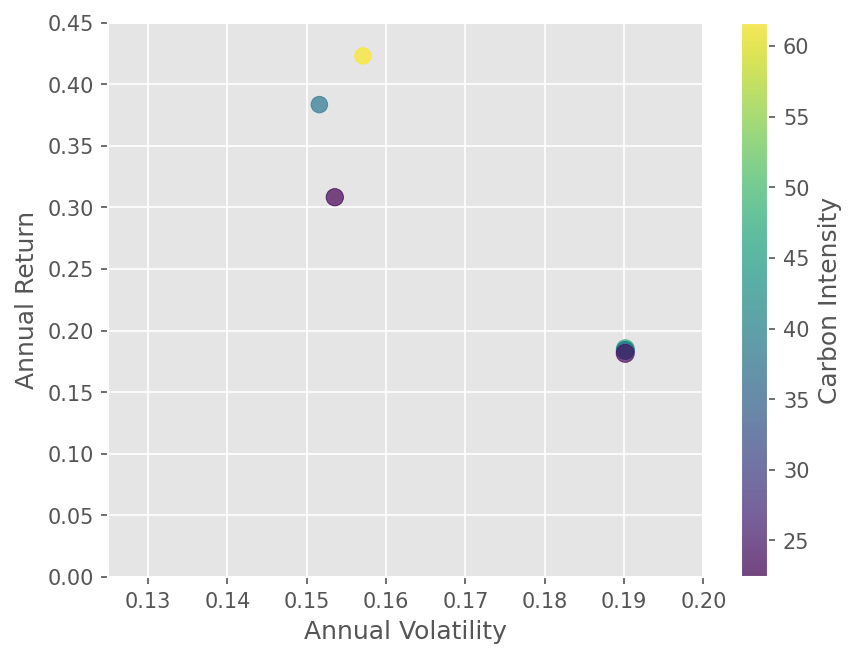

In [72]:
df_plot = pd.concat([bp, tp, p1, p2, p3, p4, p5])[['Annual Return', 'Annual Volatility']]
df_plot.merge(df_emissions_summary[['Carbon Intensity', 'ESG Score']], left_index=True, right_index=True).plot(
    kind='scatter', s='ESG Score', c='Carbon Intensity', x='Annual Volatility', y='Annual Return', cmap='viridis', alpha=0.7)
plt.xlim((0.125, 0.2))
plt.ylim((0, 0.45))
plt.show()